In [2]:
%load_ext autoreload
%autoreload 2
import os
import json
import numpy as np
import pandas as pd
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path

MPL_CUSTOM = {
    'font.family': 'serif',
    'mathtext.fontset': 'cm',
    'figure.dpi': 120,
    'figure.figsize': (4, 3.5),
    'figure.facecolor': 'white',
    'xtick.top': True,
    'xtick.direction': 'in',
    'xtick.minor.visible': True,
    'ytick.right': True,
    'ytick.direction': 'in',
    'ytick.minor.visible': True,
}

for k, v in MPL_CUSTOM.items():
    mpl.rcParams[k] = v

In [3]:
current_dir = Path(os.getcwd())
project_dir = current_dir.parent.parent.absolute()

## Key notes
--------------------------------------------
- In last notebook we deblur source function from noisy correlation using RL algorithm with total variation regularization
- one disadvantange of TV is that the normalization constraint would be destroyed over prolong iteration
- In this notebook, we deblur source function using Maximum-Entropy method, as introduced by Lucy 1994.
    

### 0. preparation
-------------------------
All essential steps except regularization is the same as the last notebook.

In [4]:
def gaus_source(r, R, lambda_=1.):
    return lambda_ / (2 * np.sqrt(np.pi) * R)**3 * np.exp(-r**2 / 4 / R**2)

R_true = 3.5
lambda_true = 0.8

In [5]:
# kernel fine-binned in r
q_fine, r_fine, kernel_fine = np.load(str(project_dir / 'database/kernel/pp/4mev.npz')).values()
source_truth = gaus_source(r_fine, R_true, lambda_true)
K_fine = 4 * np.pi * (kernel_fine+1/lambda_true) * r_fine**2 * (r_fine[1]-r_fine[0])
correlation_truth = np.dot(K_fine, source_truth)

### 1. construct coarse-binned kernel
-----------------------------------------
To choose the binning in `r`, we need to consider
- away from origin due to the $r^2$ dependence in the Koonin-Pratt equation
- the associated correlation function calculated with finite sum is consistent with the truth

In [6]:
q, r, dr, kernel = np.load(str(project_dir / 'database/kernel/pp/custom.npz')).values()
K = 4 * np.pi * (kernel+1/lambda_true) * r**2 * dr
source_coarse = gaus_source(r, R_true, lambda_true)
correlation_coarse = np.dot(K, source_coarse)

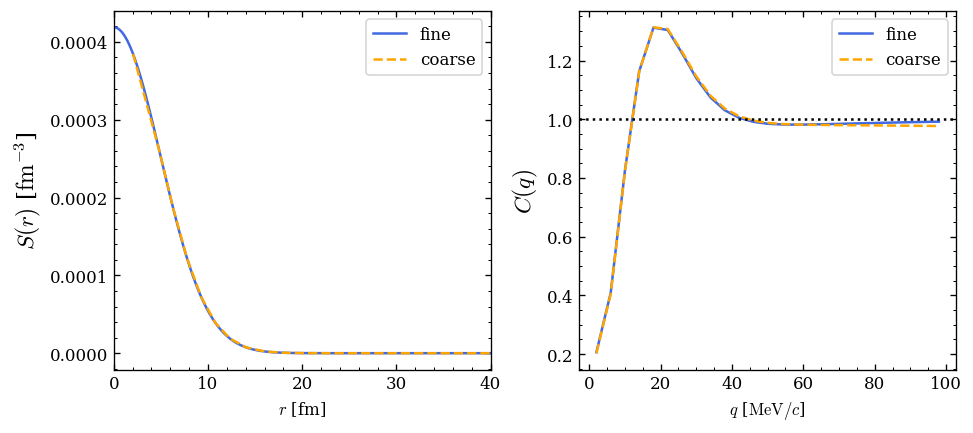

In [7]:
fig, axes = plt.subplots(1,2,figsize=(8,3.5),constrained_layout=True,dpi=120)

axes[0].plot(r_fine, source_truth, label='fine', color='royalblue')
axes[0].plot(r, source_coarse, label='coarse', ls='--', color='orange')
axes[1].plot(q_fine, correlation_truth, label='fine', color='royalblue')
axes[1].plot(q, correlation_coarse, label='coarse', ls='--', color='orange')
axes[1].axhline(1, color='k', ls=':')

axes[0].set_xlim(0,40)
axes[0].set_xlabel(r'$r$ [fm]')
axes[0].set_ylabel(r'$S(r)$ [$\mathrm{fm}^{-3}$]', fontsize=14)
axes[1].set_xlabel(r'$q$ [$\mathrm{MeV}/c$]')
axes[1].set_ylabel(r'$C(q)$', fontsize=14)

for ax in axes:
    ax.legend()

plt.show()

## remarks
--------------
- the resulting correlation deviates from the truth generated with fine-binned kernel, especially at large q. However, it should show little effect on deblurring since the tail is mostly flat and the error in this region is essentially small. An improvement would be to consider trapezoidal rule when construct the $\mathcal{K}$ matrix.
- the resulting correlation is consistent with the truth for all reasonable values of parameter `R_true`, `lambda_true`.
- if an unrealistic source such as an exponential function is used, the above agreement would be lost.

## Load realistic data
----------------------------------------
The previous part describes the choice in binning the kernel. Here, we pre-construct the correlation function with the same parameter and perturb the resulting correlation function according to experimental errorbars, i.e.

$$ C \sim \mathcal{N}(C, \delta C)$$


In [8]:
data_dir = project_dir / 'database/cf/pp/gaussian'
truth = pd.read_csv(data_dir / 'true.csv')
blurred = pd.read_csv(data_dir / 'blurred.csv')
blurred.query('y != 0 & yerr > 0', inplace=True)
q_indices = np.digitize(blurred.x.values, q, right=True)

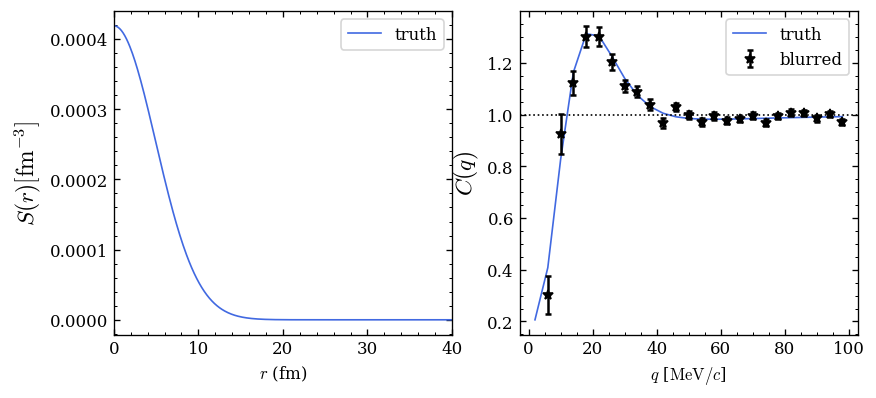

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))

axes[0].plot(r_fine, source_truth, label='truth', lw=1, color='royalblue')
axes[1].plot(truth.x.values, truth.y.values, label='truth', lw=1, color='royalblue')
axes[1].errorbar(
    blurred.x.values, blurred.y.values, yerr=blurred.yerr.values, label='blurred', marker='*', color='k',
    capsize=2, capthick=1.5, ls='none'
)

axes[0].set_xlim(0, 40)
axes[1].axhline(1, color='k', ls=':', lw=1)

for ax in axes:
    ax.legend()

axes[0].set_xlabel(r'$r$ (fm)')
axes[1].set_xlabel(r'$q$ [$\mathrm{MeV}/c$]')
axes[0].set_ylabel(r'$S(r) [\mathrm{fm}^{-3}]$', fontsize=14)
axes[1].set_ylabel(r'$C(q)$', fontsize=14)
plt.show()

## Maximum-Entropy regularized RL
----------------------------------------
Rewrite the standard RL as an addicitive update:
$$
    \Delta^H \mathcal{S}_j^{(r)} = \mathcal{S}_j^{(r)} \bigg[\sum_i \dfrac{\tilde{\mathcal{C}}_i}{\mathcal{C}_i^{(r)}}\mathcal{K}_{ij} - 1\bigg]
$$

MEM regularization refers to an additional updates:
$$
    \Delta^\mathbb{S}\mathcal{S}_j = -\alpha \mathcal{S}_j \bigg[
        \mathbb{S} + \ln \dfrac{\mathcal{S}_j}{\chi_j} + 1 - \sum_k \dfrac{\mathcal{S}_k}{\chi_k}\Pi_{kj}
    \bigg]
$$

where $alpha$ refers to the regularization strength and the rest of the quantities are defined as 
- entropy term $\mathbb{S}$
    $$
        \mathbb{S} = -\sum_j \mathcal{S}_j\ln \dfrac{\mathcal{S}_j}{\chi_j}
    $$
- default solution / prior of the source function $\chi$ constructed by
    $$
        \chi_j = \sum_k \Pi_{jk} \mathcal{S}_k
    $$
- symmetric matrix $\Pi$ serves to construct the prior above, usually taken as gaussian as a smoothing kernel
    $$
        \Pi_{jk} \propto \exp(-\dfrac{(r_j - r_k)^2}{2\sigma_r^2})
    $$

### Remark
------------
- normalization constraint is respected : $\sum_j \Delta^{\mathbb{S}}\mathcal{S}_j = 0$
- $\chi_j = \sum_k \Pi_{jk} \mathcal{S}_k$ where $\Pi_{jk} \propto \exp(-\dfrac{(r_j - r_k)^2}{2\sigma_r^2})$

In [10]:
def richardson_lucy_me(niter, X, y, psf, Pi, alpha=0., accelerated=True, accel_rate=2.0, return_all=False):
    y_norm = np.sum(y)
    psf_norm = np.sum(psf, axis=0)

    psf_ = psf / psf_norm
    img = y / y_norm
    Pi_ = Pi / np.sum(Pi, axis=0)

    deconv = X / np.sum(X)
    conv = np.dot(psf_, deconv) + 1e-12

    X_preds = []
    y_preds = []
    ts = []

    for _ in range(niter):
        deltaH = deconv * (np.einsum('i,ij', img / conv, psf_) - 1)
        # conservation of flux
        assert np.abs(np.sum(deconv) - 1) < 1e-6
        assert np.abs(np.sum(deltaH)) < 1e-6

        deltaS = np.zeros_like(deconv)
        if alpha != 0:
            chi = np.dot(Pi_, deconv)
            Sratio = deconv / chi
            lnSratio = np.log(Sratio)
            S = - np.sum(deconv * lnSratio)
            deltaS = -alpha * deconv * (
                1 + lnSratio + S - np.dot(Pi_.T, Sratio)
            )
            assert np.abs(np.sum(deltaS)) < 1e-6

        delta = deltaH + deltaS

        accel = 1.
        if accelerated:
            # from positivity constraint
            accel_c = np.divide(deconv, np.abs(delta), out=np.zeros_like(deconv), where=delta!=0)
            accel_c = accel_c[delta < 0].min()
            accel = min(accel_c, accel_rate)
            assert accel > 1

        deconv = deconv + accel * delta
        conv = np.dot(psf_, deconv) + 1e-12
        t = np.abs(delta) / (np.abs(deltaH) + np.abs(deltaS))

        X_preds.append(deconv * y_norm / psf_norm)
        y_preds.append(conv * y_norm)
        ts.append(t)

        if alpha > 0. and np.all(t < 1e-3):
            break
    
    if return_all:
        return X_preds, y_preds, ts
    return X_preds[-1], y_preds[-1], ts[-1]

In [11]:
def construct_Pi(r, sigma):
    simple_gaussian = lambda x, mu, s : 1 / np.sqrt(2 * np.pi * s**2) * np.exp(-(x - mu)**2 / 2 / s**2)
    return np.array([
        [simple_gaussian(rj - rk, 0, sigma) for rj in r] for rk in r
    ])

In [12]:
lambda_guess = 0.8

In [13]:
flat_guess = np.ones_like(r)
flat_guess /= np.sum(flat_guess * 4 * np.pi * r**2 * dr)
flat_guess *= lambda_guess

In [14]:
K = 4 * np.pi * (kernel + 1./ lambda_guess) * r ** 2 * dr

In [15]:
alpha = 0.3
sigma_r = 0.9

In [16]:
niter = 150000
restored_list, predicted_list, t_list = richardson_lucy_me(
    niter = niter, 
    X = flat_guess,
    y = blurred.y.values,
    psf = K[q_indices,:],
    return_all = True,
    accelerated = True, 
    accel_rate = 1.99,
    alpha = alpha,
    Pi = construct_Pi(r, sigma_r)
)

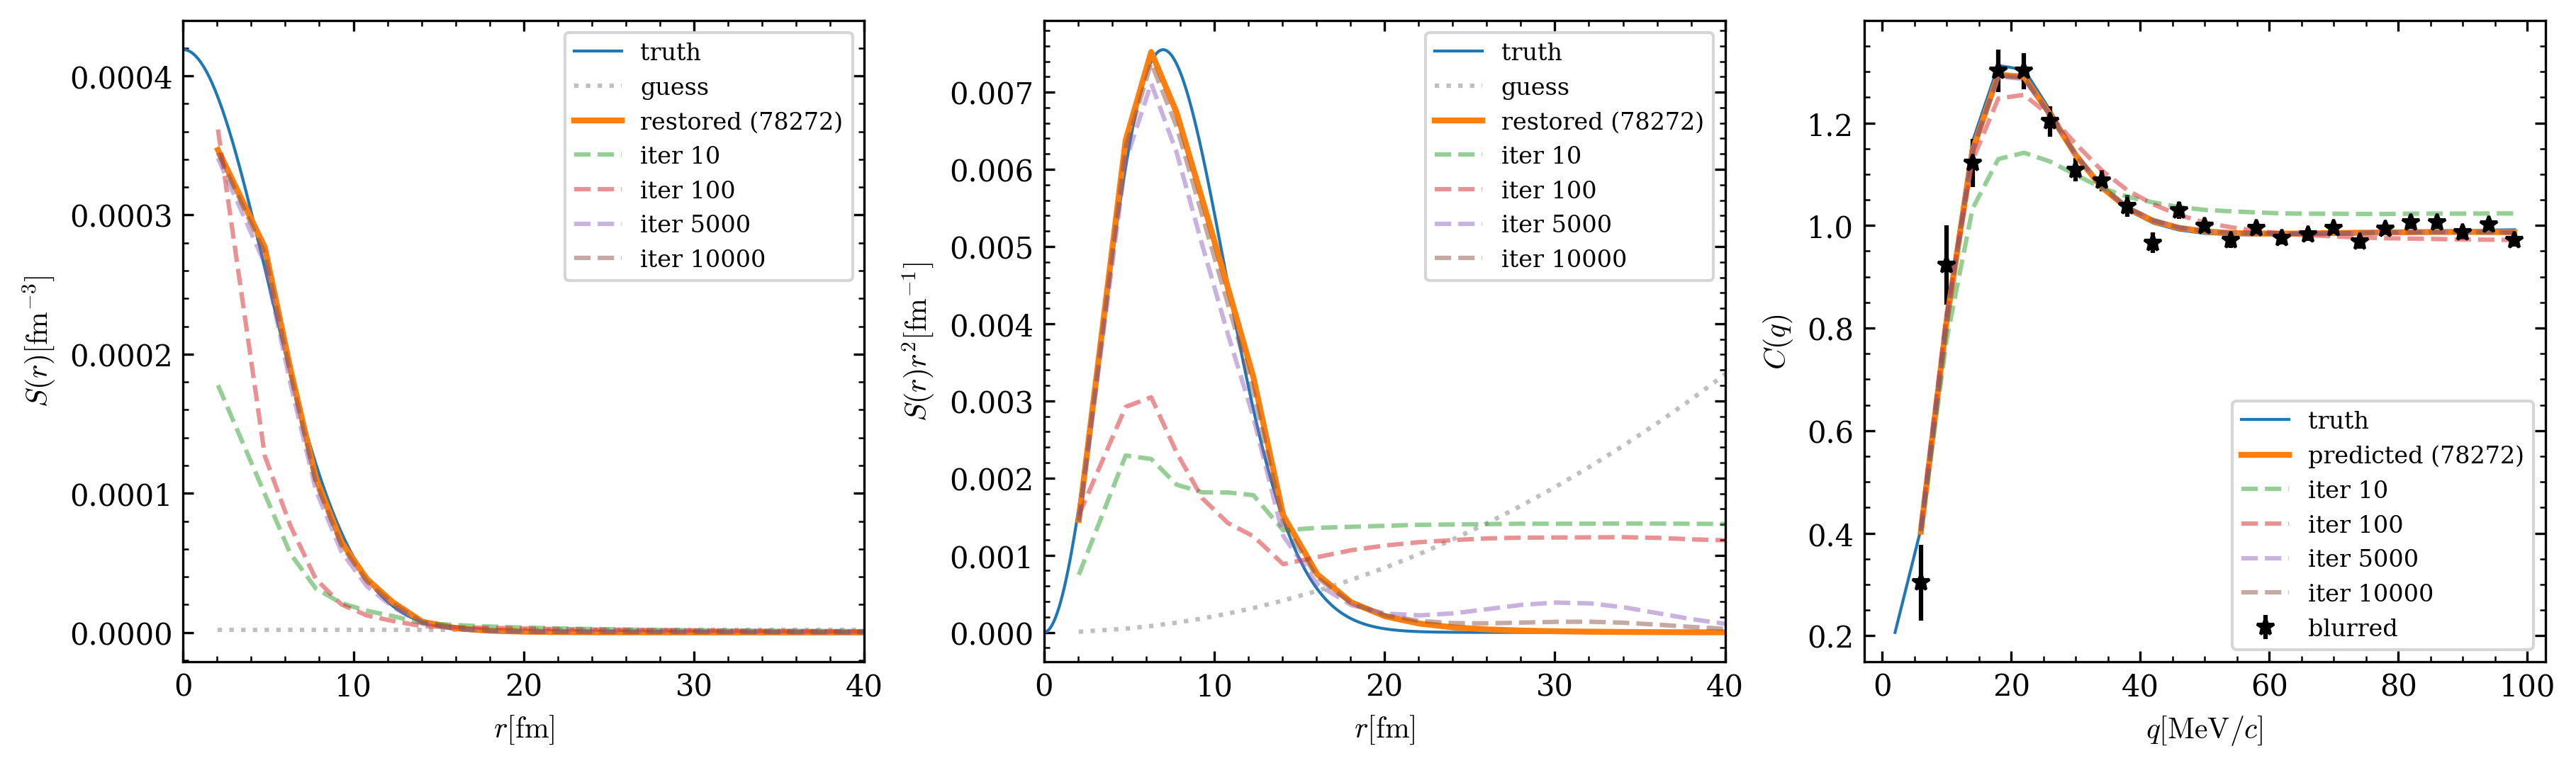

In [17]:
fig, axes = plt.subplots(1,3,figsize=(12,3.5),constrained_layout=True,dpi=300)

axes[0].plot(r_fine, source_truth , label='truth', lw=1)
axes[0].plot(r, flat_guess, label='guess', ls=':', color='gray', alpha=0.5)
axes[0].plot(r, restored_list[-1], label=f'restored ({len(restored_list):0d})', ls='-', lw=2)
axes[1].plot(r_fine, source_truth * r_fine**2 , label='truth', lw=1)
axes[1].plot(r, flat_guess * r**2, label='guess', ls=':', color='gray', alpha=0.5)
axes[1].plot(r, restored_list[-1] * r**2, label=f'restored ({len(restored_list):0d})', ls='-', lw=2)
axes[2].plot(q, correlation_truth, label='truth', lw=1)
axes[2].errorbar(
    blurred.x.values, blurred.y.values, yerr=blurred.yerr.values, 
    label='blurred', marker='*', color='k', ls='none'
)
axes[2].plot(blurred.x.values, predicted_list[-1], label=f'predicted ({len(predicted_list):0d})', ls='-', lw=2)

for i, epoch in enumerate([10, 100, 5000, 10000, 100000]):
    if epoch > len(restored_list):
        continue
    axes[0].plot(r, restored_list[epoch - 1], ls='--', label=f'iter {epoch}', alpha=0.5)
    axes[1].plot(r, restored_list[epoch - 1] * r**2, ls='--', label=f'iter {epoch}', alpha=0.5)
    axes[2].plot(blurred.x.values, predicted_list[epoch - 1], ls='--', label=f'iter {epoch}', alpha=0.5)

axes[0].set_xlim(0, 40)
axes[0].set_xlabel(r'$r [\mathrm{fm}]$')
axes[0].set_ylabel(r'$S(r)  [\mathrm{fm}^{-3}]$')

axes[1].set_xlim(0, 40)
axes[1].set_xlabel(r'$r [\mathrm{fm}]$')
axes[1].set_ylabel(r'$S(r) r^2 [\mathrm{fm}^{-1}]$')

axes[2].set_xlabel(r'$q [\mathrm{MeV}/c]$')
axes[2].set_ylabel(r'$C(q)$')

axes[0].legend(loc='upper right', fontsize=8)
axes[1].legend(loc='upper right', fontsize=8)
axes[2].legend(loc='lower right', fontsize=8)

plt.show()